In [1]:
import numpy as np
import run_continuum as run
import matplotlib.pyplot as plt
import scipy.signal
import scipy as scp

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up a few different friction law classes:
class VelocityWeakeningFrictionLaw:
    
    def __init__(self,weakeningConstant):
        self.weakeningConstant = weakeningConstant
        
    def getFriction(self,x,u,v,tau,stuck): # Define as positive
#        return np.sign(v)*(1-tau)*1/(1+self.weakeningConstant*np.abs(v))
        return np.sign(v)*1/(1+self.weakeningConstant*np.abs(v))
    
    def step(self,x,u,v,tau,stuck):
        return

    
class SlipWeakeningFrictionLaw:
    
    def __init__(self,weakeningConstant,delta_u):
        self.weakeningConstant = weakeningConstant
        self.delta_u = delta_u
        
    def getFriction(self,x,u,v,tau,stuck):
        self.delta_u = u
        #self.delta_u[stuck==True]=0 #TODO: fix "restart"
#        return np.sign(v)*(1-tau)*1/(1+self.weakeningConstant*np.abs(self.delta_u))
        return np.sign(v)*1/(1+self.weakeningConstant*np.abs(self.delta_u))
    
    def step(self,x,u,v,tau,stuck):
        return
        

In [3]:
# Create pulse prediction function
def PulsePrediction(startPos,u,x,tau,gamma):
    u_pred = np.zeros(np.size(x))
    u_pred[startPos]=u[startPos,-1]

    for i in range(startPos+1,len(x)):
        stress_drop = 2*tau[i-1]
        dx = x[i]-x[i-1]
        u_pred[i] = u_pred[i-1] + .5*(stress_drop - gamma*u_pred[i-1])*dx
    
    # Prediction of arrest where u_pred<0
    try:
        ind = np.where(u_pred<0)
        u_pred[ind[0][0]:]=0
    except:
        pass
    
    return u_pred

# Transition from crack to pulse
Run an example to show the transition from crack-like to pulse-like propagation

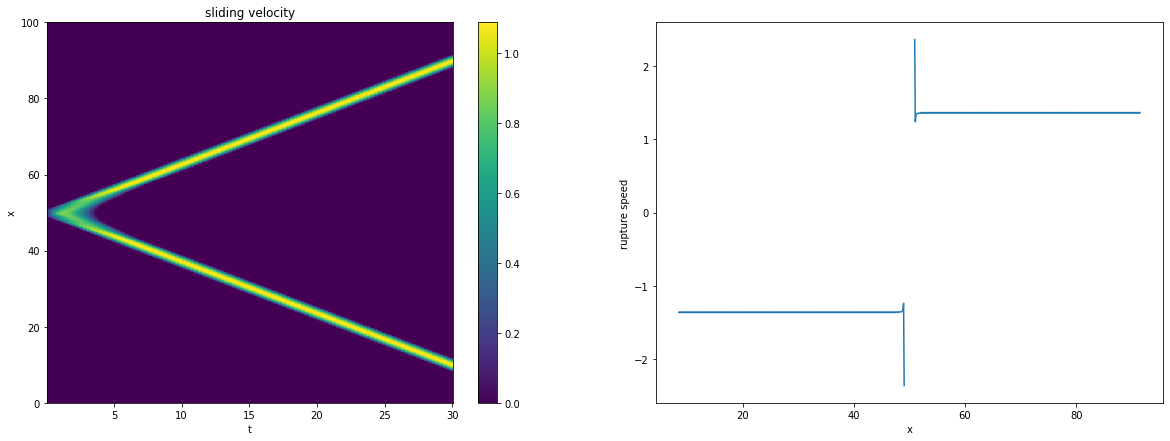

In [4]:
x = np.linspace(0,100,1000)
dt = 1e-3
tmax = 30
gamma = 0.65
beta = 0.01
tau = 0.6*np.ones(np.size(x))
tau[490:510]=1
output_interval = 100

data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.pcolor(data['t'],x,data['v'],shading='auto')
plt.ylabel('x')
plt.xlabel('t')
plt.title('sliding velocity')
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(x,np.gradient(x)/np.gradient(data['unstickTime']))
plt.ylabel('rupture speed')
plt.xlabel('x')

plt.show()

# Predictions for rupture arrest

### Pulse propagation and prediction of arrest location and final slip

Now set up rupture from one side so that the boundary acts as a barrier (this is directly coded in run_continuum).

We will use this to find out how to predict rupture arrest, as well as final slip profile.

In [5]:

# Create a small dataset with different decaying taubar

dt = 1e-3
tmax = 50
gamma = 0.8
beta = 0.01
output_interval = 100
N_runs = 9
dataPulse = []

for runInd in range(N_runs):
    
    x = np.linspace(0,40*float(np.random.rand(1)+.2),1000)

    # Create tau from correlated noise:
    correlation_scale = .1+np.random.rand(1)
    filter_kernel = np.exp(-(x-np.max(x)/2)**2/(2*correlation_scale))
    filter_kernel = filter_kernel/np.sum(filter_kernel)
    noise = np.random.randn(np.size(x))
          
    noise = scipy.signal.convolve(noise, filter_kernel, mode='same')
    noise = noise-np.min(noise); noise = noise/np.max(noise)
    noise = noise*(1-np.exp(-x/5))
    randMod = .2+.8*np.random.rand(1)
    tau = randMod*noise+(1-randMod*(1-np.exp(-x/5)))-(x/np.max(x)) # Add linear background to noise
    tau[0:1]=1

    # run
    dataPulse.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta))
    

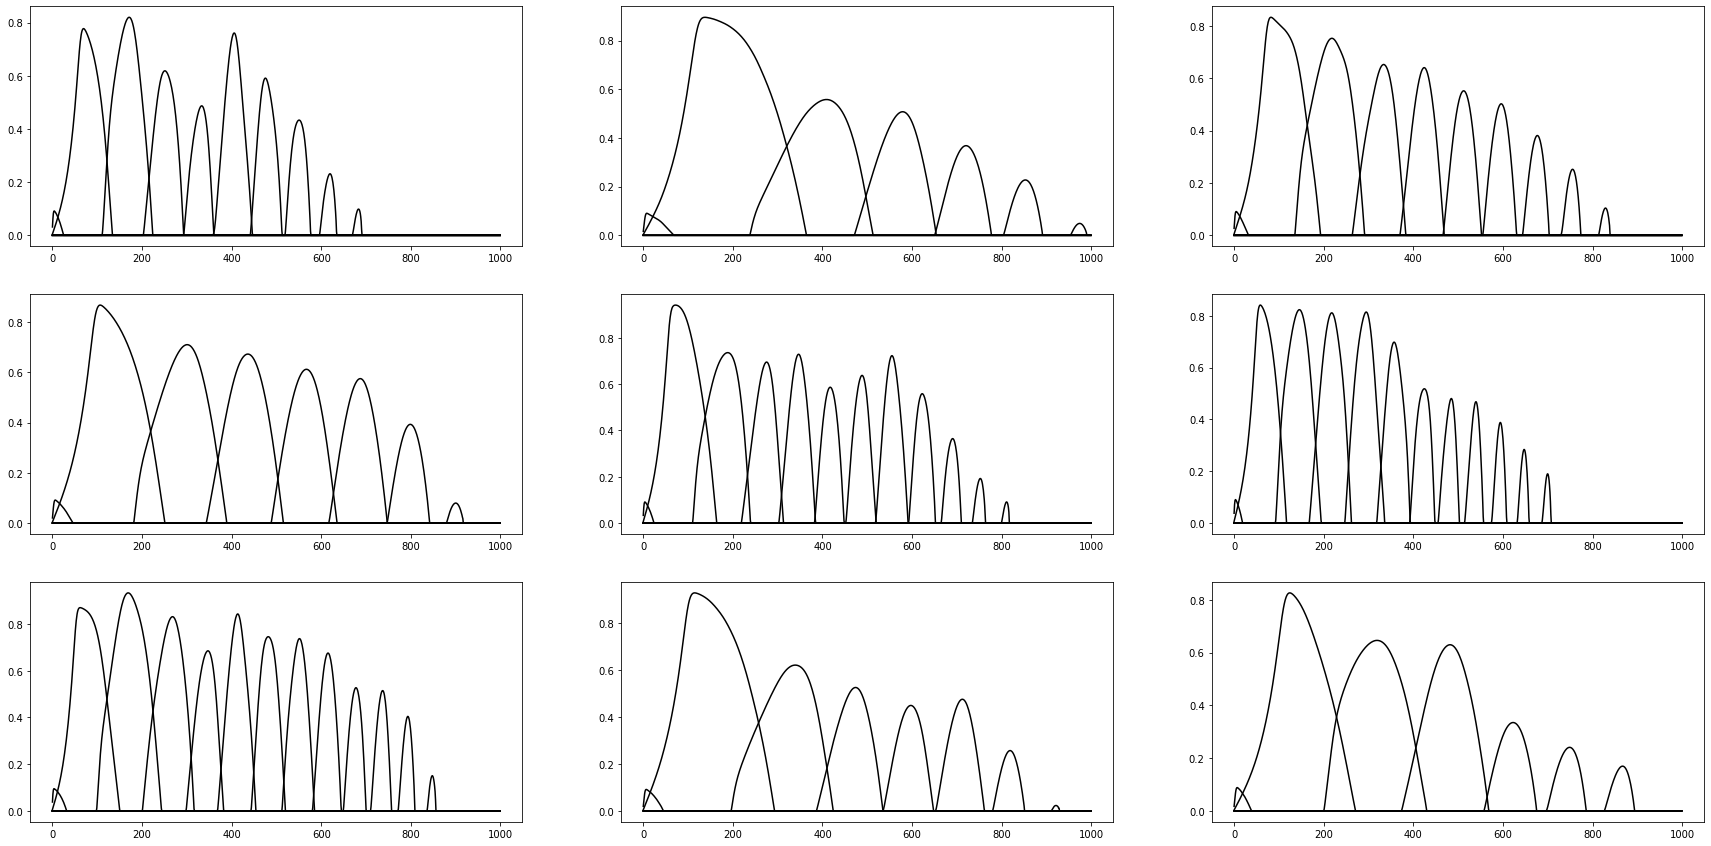

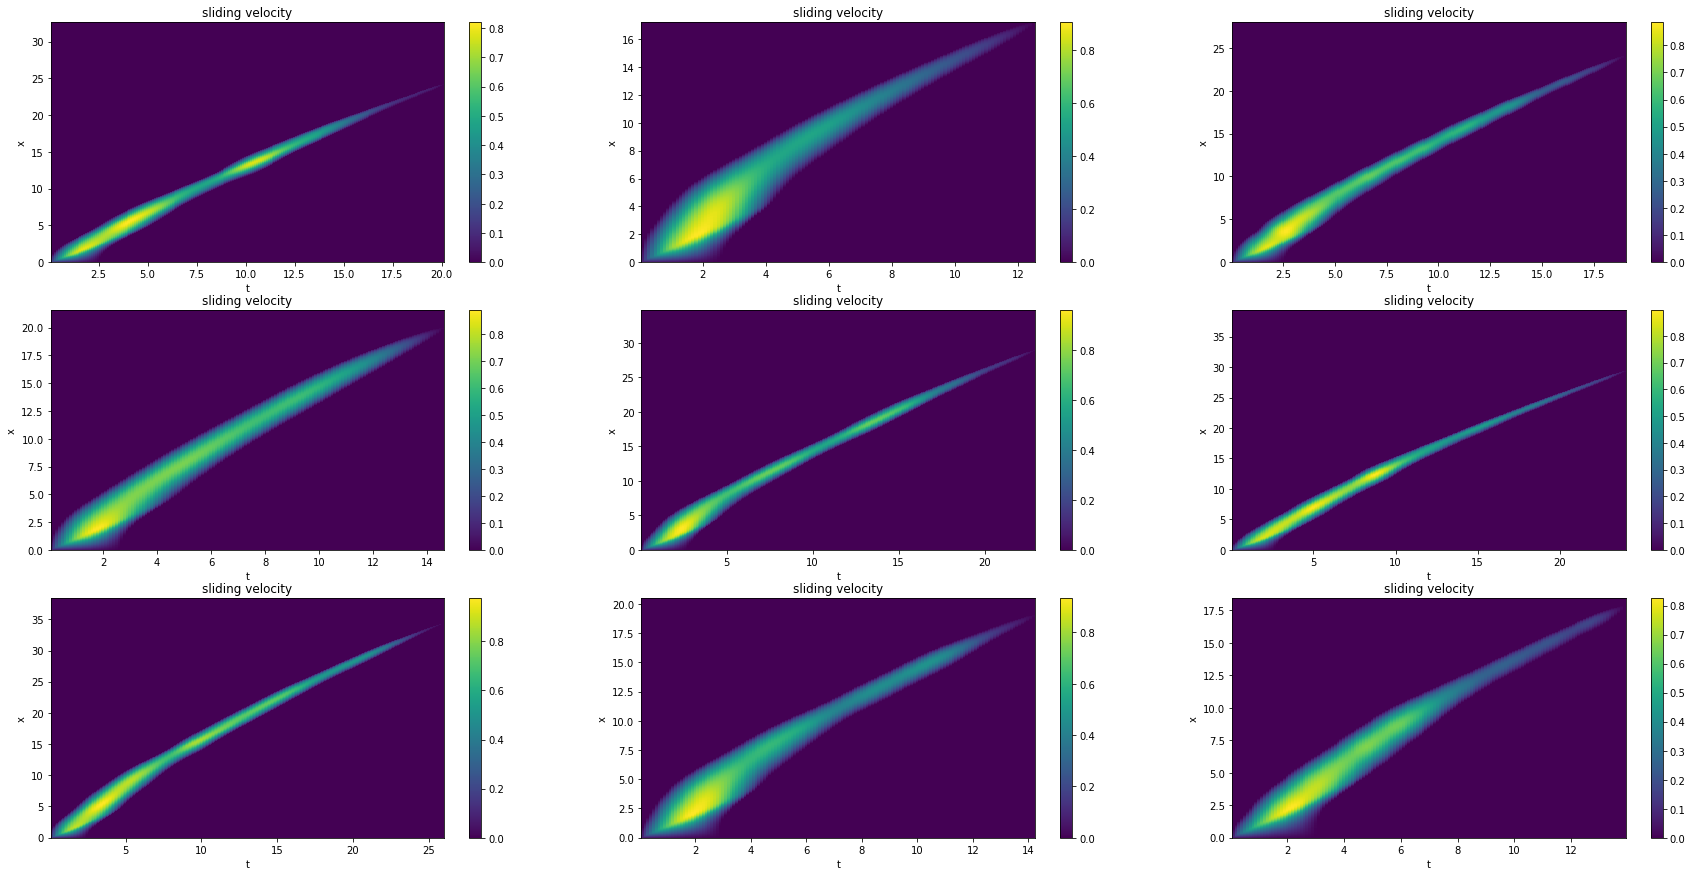

In [6]:
# Plot some example pulses
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    Nmax = len(dataPulse[runInd]['t'])
    plt.plot(dataPulse[runInd]['v'][:,range(0,Nmax-1,20)],'k')
plt.show()

plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.pcolor(dataPulse[runInd]['t'],dataPulse[runInd]['x'],dataPulse[runInd]['v'],shading='auto')
    plt.ylabel('x')
    plt.xlabel('t')
    plt.title('sliding velocity')
    plt.colorbar()
plt.show()


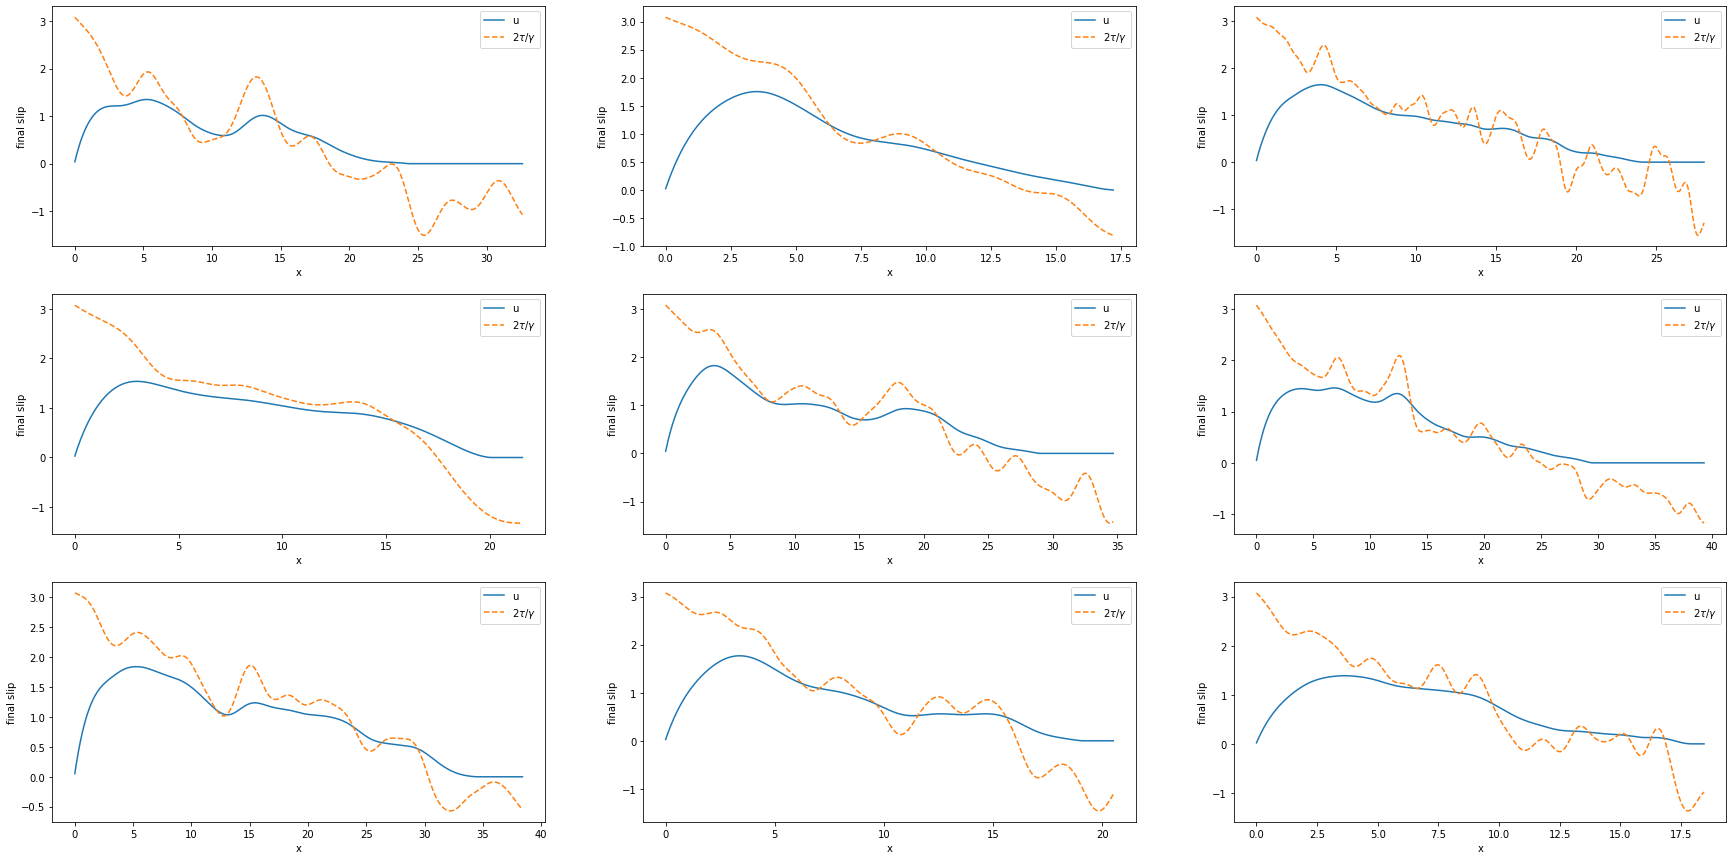

In [7]:
# Plot final slip
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataPulse[runInd]['x'],dataPulse[runInd]['u'][:,-1],label='u')
    plt.plot(dataPulse[runInd]['x'],2*dataPulse[runInd]['tau']/data['gamma'],label='$2\\tau/\\gamma$',linestyle='--')
    plt.xlabel('x')
    plt.ylabel('final slip')
    plt.legend()
plt.show()

The final slip has above been compared to the slip assuming steady state at all times: $2\tau/\gamma$ (this comes from steady state solution of slip pulse).

Already from this it is quite clear that the final slip distribution will at least in some form resemble the initial shear stress. For small spatial variations in prestress, this prediction is atually fairly accurate.

The first order prediction assuming slowly varying prestress of where the pulse will arrest is the first point where the non-dimensional prestress drops below zero, which is a very local criteraion.



To obtain higher order approximations, there are a few possibilities. One is to find a pulse energy equation as in the fairly recent Heaton paper. It is, however, possible to perform a correction to the approximation used above.

A final slip $2\tau/\gamma$ assumes no variation of prestress and neglects stress from du/dx. 

If we instead assume that the stress drop predicted from the steady state slip pulse is correct at all times, we can correct the solution with $\partial u \partial x$. A second order correction is thus to include this term and solve the equation
\begin{equation}
2\tau = 2 \frac{\partial u}{\partial x} + \gamma u
\end{equation}
as a time-integrated problem with the initial condition u(0)=0. This equation arises from a simple force balance consideration on a single point (easily undestood from BK model at least).

Note that u here is the final slip/ total slip of a passing pulse. u is thus different from the u in the equation of motion.  This equation implicitly assumes that the pulse can be considered a point. 


@TODO: Write down entire calculation.


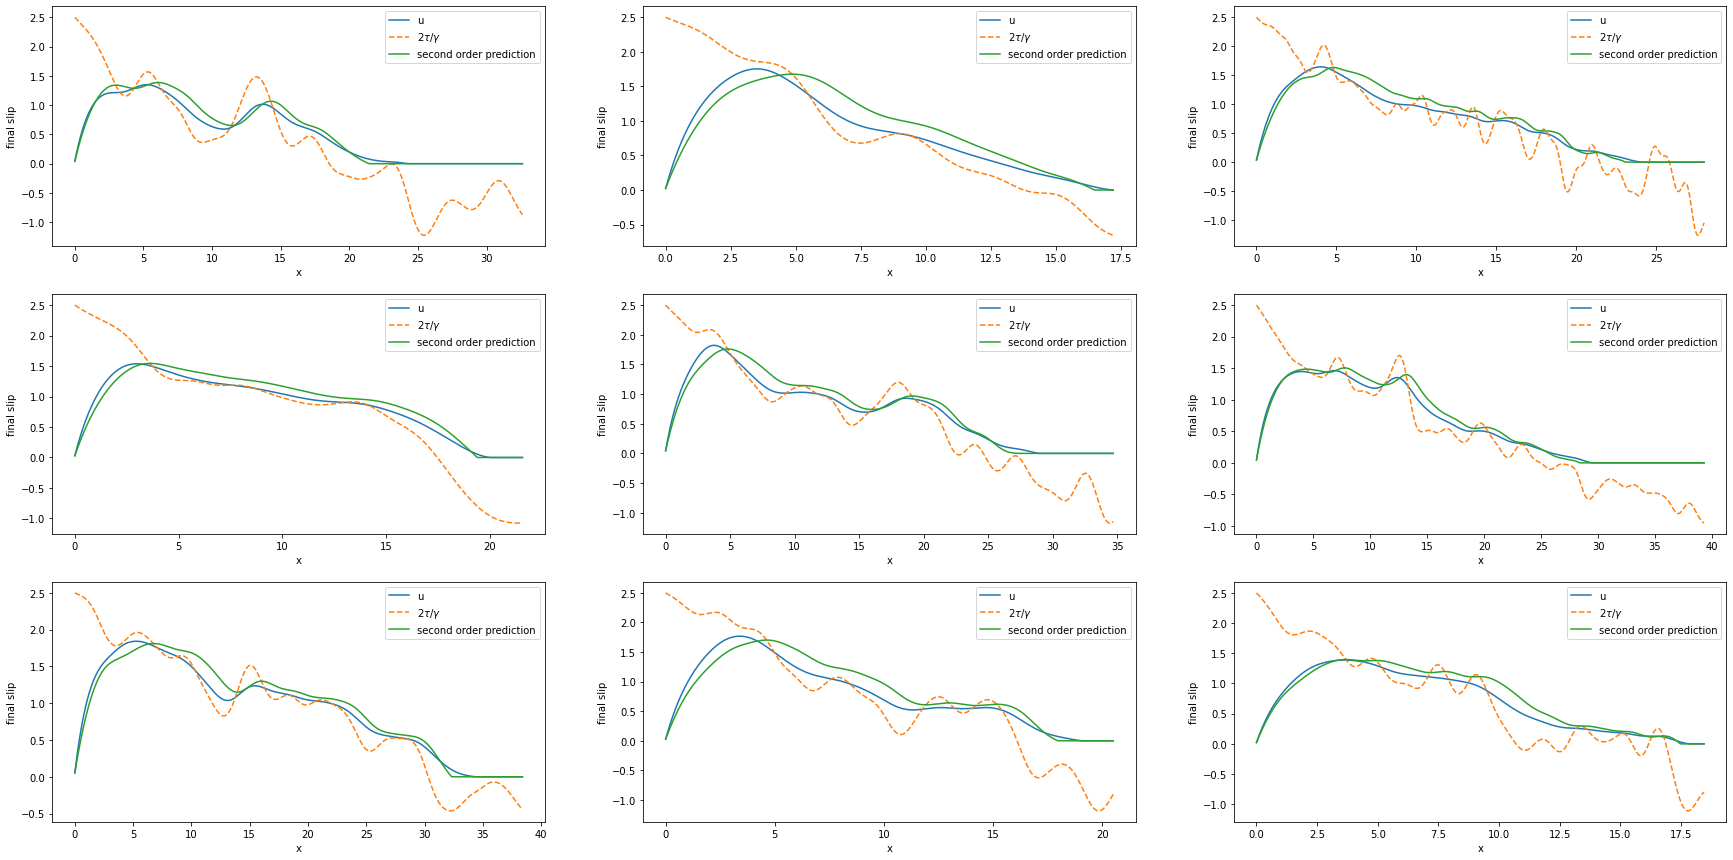

In [8]:
# Plot final slip
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    
    # calculate prediction:    
    u_pred = PulsePrediction(startPos = 0,u = dataPulse[runInd]['u'], x = dataPulse[runInd]['x'],tau = dataPulse[runInd]['tau'], gamma = dataPulse[runInd]['gamma'])
    
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataPulse[runInd]['x'],dataPulse[runInd]['u'][:,-1],label='u')

    plt.plot(dataPulse[runInd]['x'],2*dataPulse[runInd]['tau']/dataPulse[runInd]['gamma'],label='$2\\tau/\\gamma$',linestyle='--')
    plt.plot(dataPulse[runInd]['x'],u_pred,label='second order prediction',linestyle='-')
    
    plt.xlabel('x')
    plt.ylabel('final slip')
    
    plt.legend()
plt.show()

The agreement here is already quite good, but it will probably be slightly worse if we increase the frequency of the noise in tau because we do not account for the finite pulse width. Going from here to predictions of pulse arrest and triangular slip is straightforward, but what we obtain is highly dependent on the initial stress. 

We have to look into how this actually relates to the Elbanna/Heaton paper starting from pulse energy.




### Prediction of arrest and final slip for cracks
The next step is to compare this to what we would expect for crack-like rupture.


For non-local slip, the final should be found from

\begin{equation}
\frac{\partial^2 u}{\partial x^2} + \tau + \gamma u = a_{final}
\end{equation}
with $u(0)=u(L)=0$ For fixed boundaries. (in the GRL we used stress BC to trigger from one side which removes the possiility of pulses (except from pulse trains) at $\gamma=0$. This also ensures that $a_{final}$ is negligible. Here it is not really clear how best to solve this as it seems that we need a predictor for $a_{final}$. We also have the issue that there will be a transition from crack to pulse with the bc that is currenly used.

$L$ is found from 
\begin{equation}
\int_0^L \tau \text{d}x = 0
\end{equation}
This works well in the case of cracks with fixed bc. (This is basically an energy release rate, but the mathematics should be carried out carefully). Without fixed left bc, the average slip gradient is nonzero, so we also need to account for the full integrated stress drop.


For stress bc, we also need to account for the final $a$ to be accurate (although for constant $\bar \tau$ this would tend to be $0$).
$L$ is found from 
\begin{equation}
\int_0^L \tau -a \text{d}x = 0
\end{equation}


@Check: Role of velocity weakening?

@Check: Which wavelength is relevant in the prestress?


In [9]:
# Create a small dataset with different decaying taubar with gamma = 0 (both force bc and fixed bc)

dt = 1e-3
tmax = 300
gamma = 0.0
beta = 0.01
output_interval = 100
N_runs = 9
dataCrack = []
dataCrackFixedBC = []

for runInd in range(N_runs):
    
    x = np.linspace(0,40*float(np.random.rand(1)+.6),1000)

    # Create tau from correlated noise:
    correlation_scale = .1+np.random.rand(1)
    filter_kernel = np.exp(-(x-np.max(x)/2)**2/(2*correlation_scale))
    filter_kernel = filter_kernel/np.sum(filter_kernel)
    noise = np.random.randn(np.size(x))

    noise = scipy.signal.convolve(noise, filter_kernel, mode='same')
    noise = noise-np.min(noise); noise = noise/np.max(noise)
    randMod = .75+.25*np.random.rand(1)
    

    
    xMod = (4*x/np.max(x))
    xMod[x>np.max(x)/4]=1
    
    tau = randMod*noise+(1-randMod)-xMod # Add linear background to noise
#    tau = randMod*noise+(1-randMod)
    tau[0:1]=1

    # run
    dataCrack.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta,bc='force_left'))
    dataCrackFixedBC.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta,bc='fixed'))
    

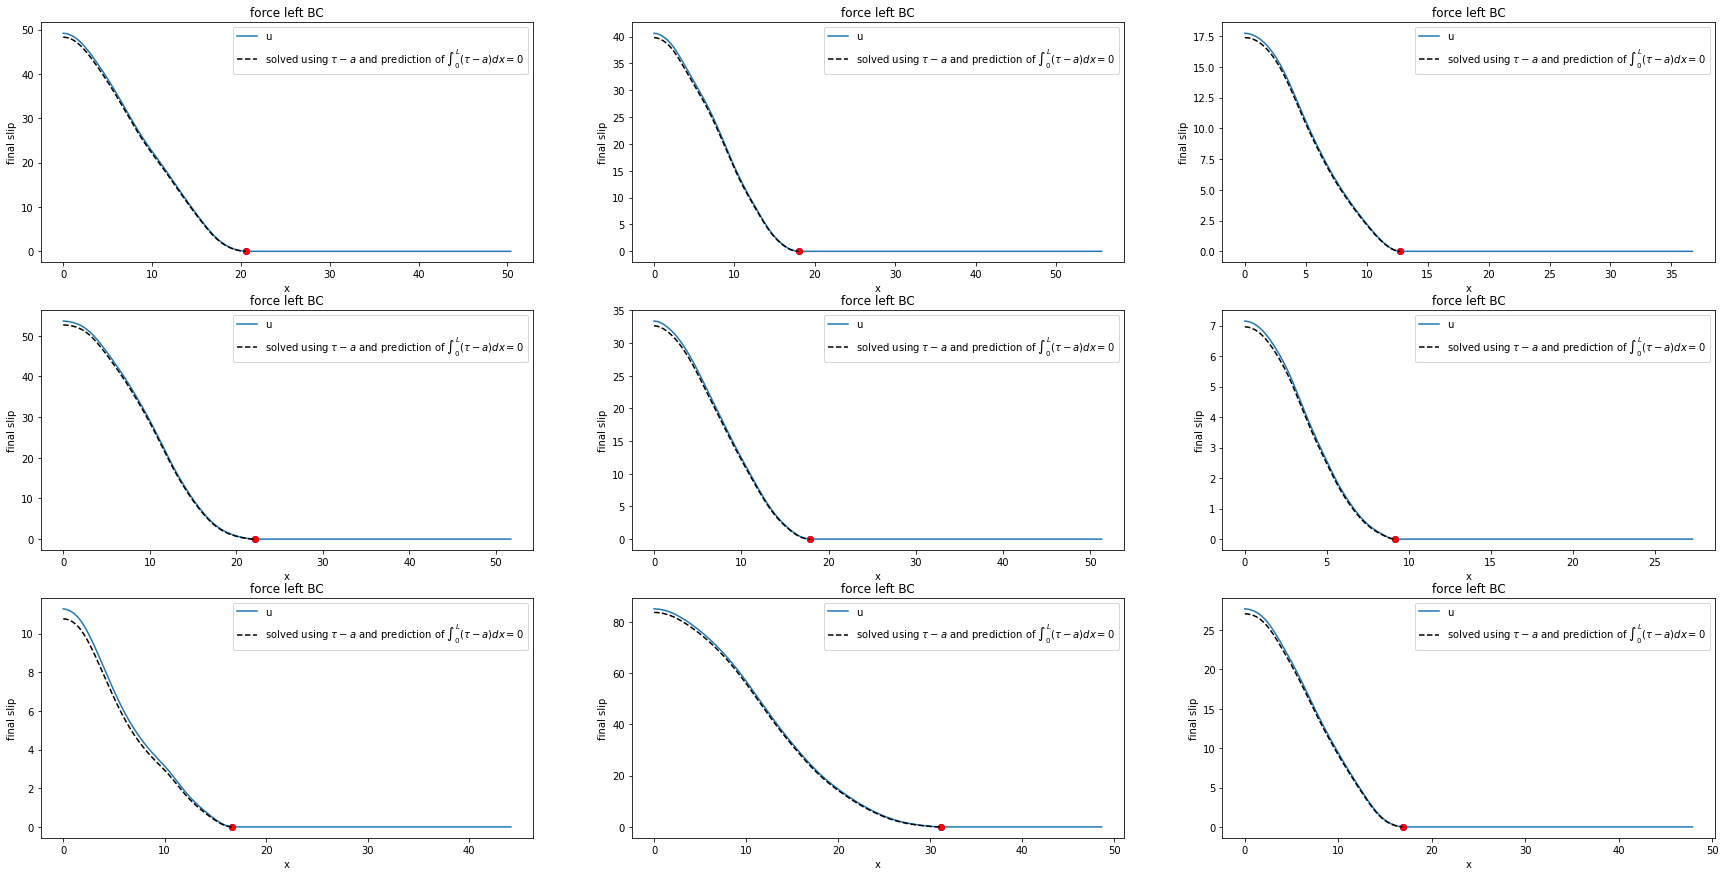

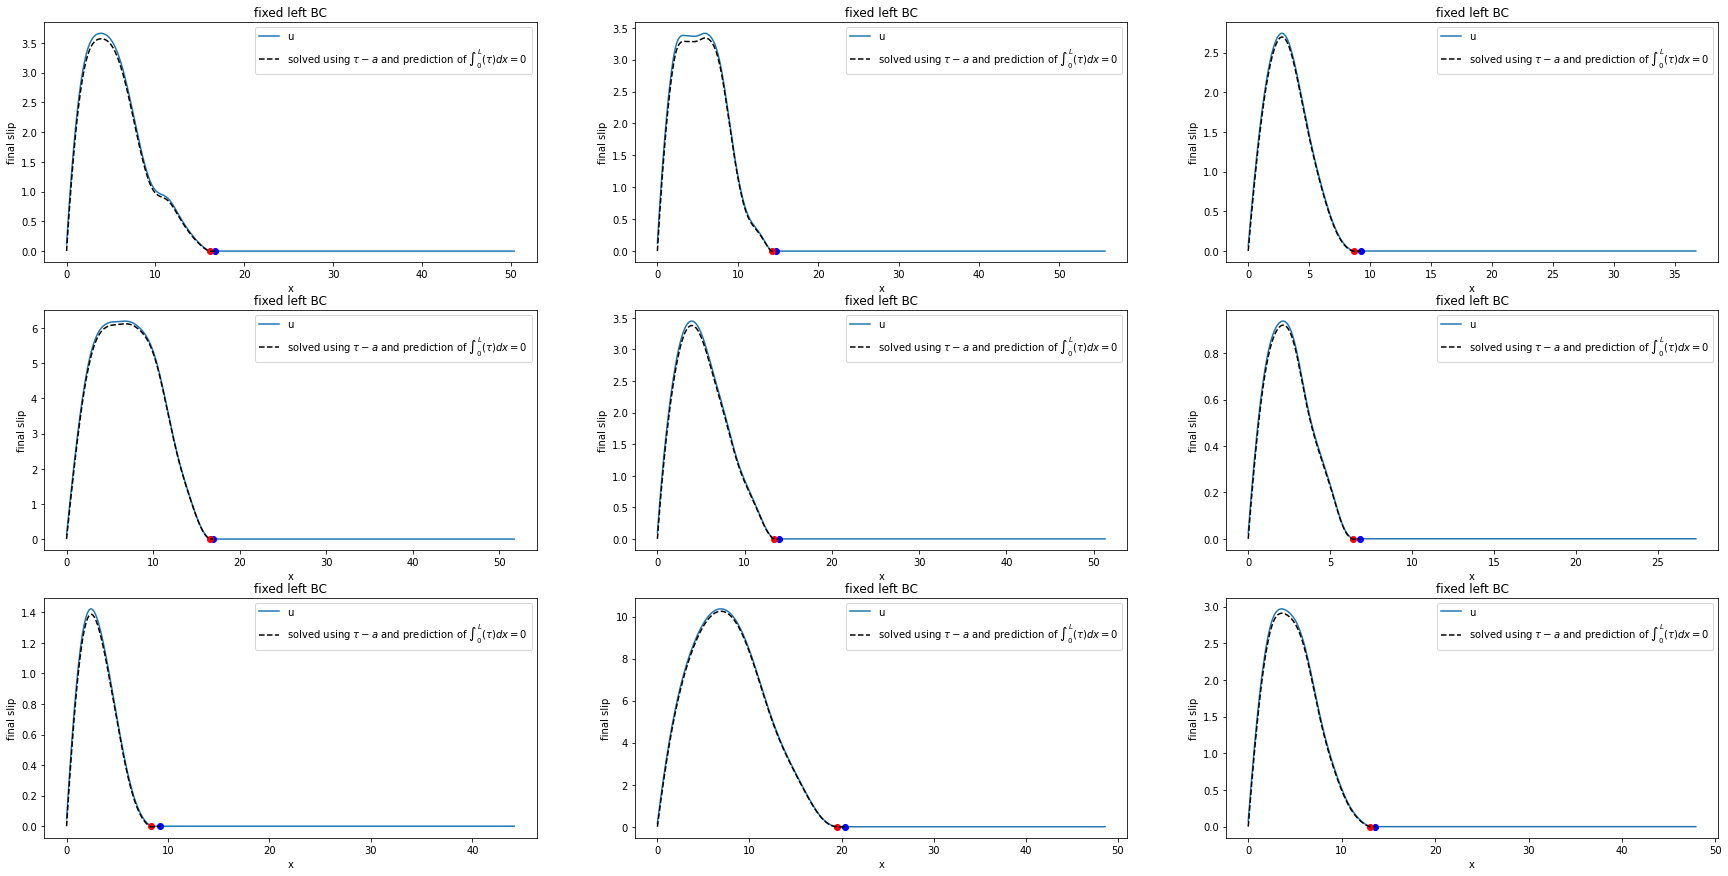

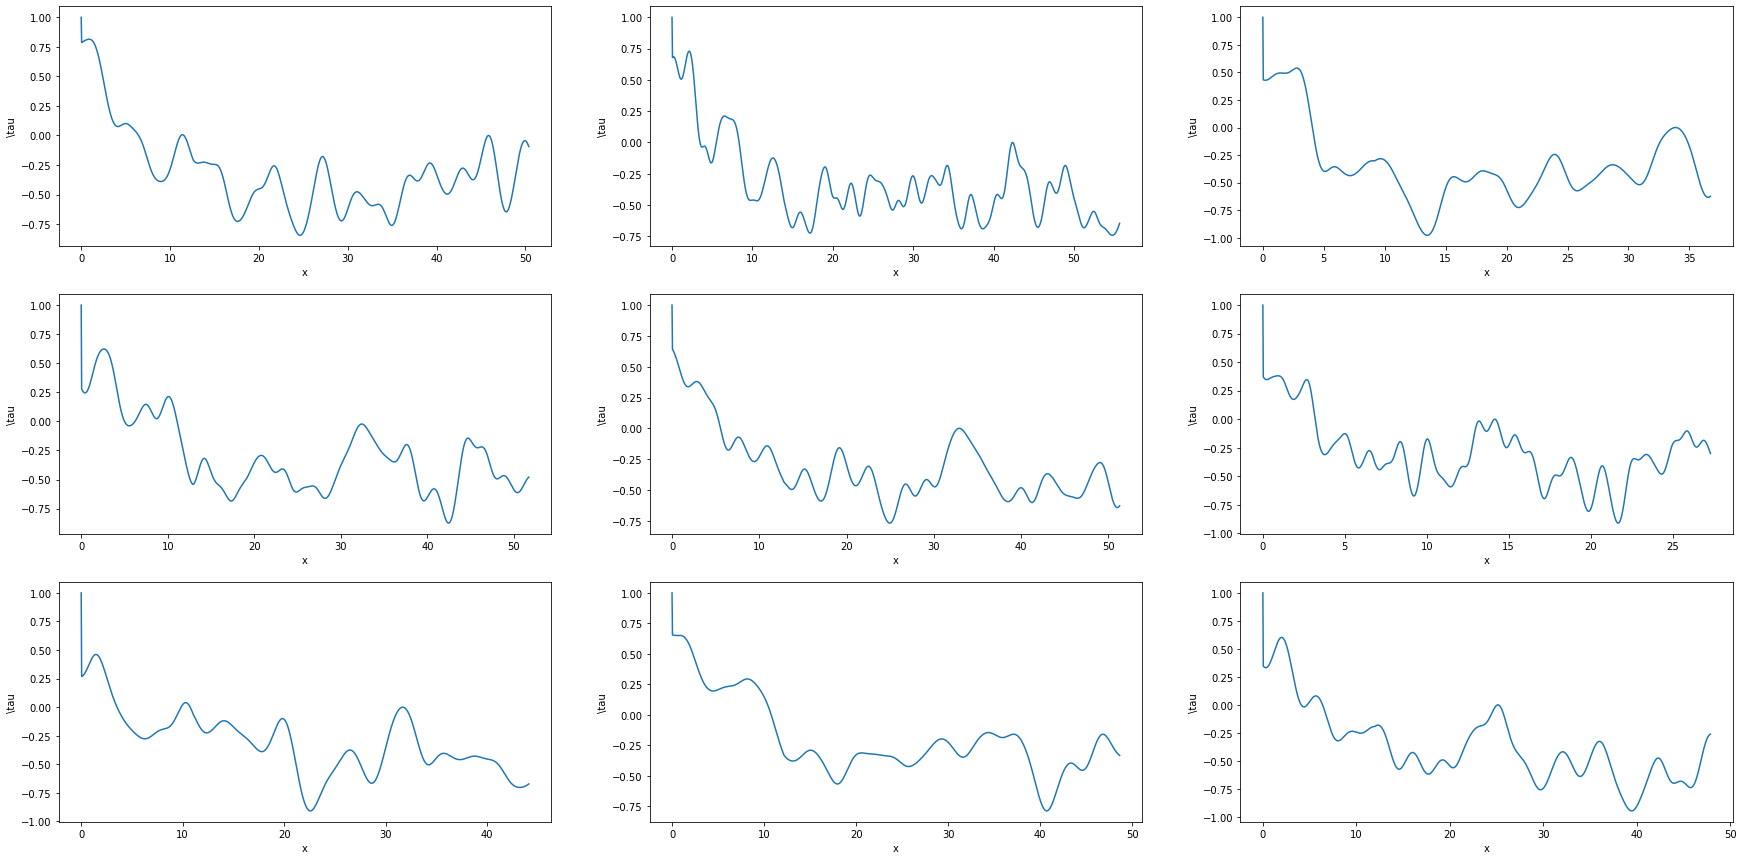

In [10]:
# Plot final slip force BC
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataCrack[runInd]['x'],dataCrack[runInd]['u'][:,-1],label='u')
    
    # calculate prediction:
    try:
        tmp = np.where(np.sum(dataCrack[runInd]['stuck']==False,1)==0); L_true = dataCrack[runInd]['x'][tmp[0][0]] # True length

        tmp = np.cumsum(dataCrack[runInd]['tau'] - dataCrack[runInd]['a'][:,-1])*dataCrack[runInd]['x'][1]
        L_prediction = dataCrack[runInd]['x'][np.where(tmp<1e-10)[0][0]]
        plt.plot(L_prediction,0,'ob')
        plt.plot(L_true,0,'or')
        
        #TODO: This is a global criterion:
        # 1) Find the arrest based on integral over tau
        # 2) Find slip from eom with u=0 at boundaries (see GRL for reference).
        from scipy.sparse import spdiags
        from scipy.sparse import csc_matrix
        from scipy.sparse.linalg import dsolve
        xP = np.linspace(0,L_prediction,1000)

        dx = xP[1]
        tauP = np.interp(xP,dataCrack[runInd]['x'],dataCrack[runInd]['tau']-dataCrack[runInd]['a'][:,-1])
        
        N_intervals = np.size(xP)-1
        rhs = dx*dx*tauP
        rhs[0] = 0
        rhs[-1] = 0
        #A = csc_matrix(spdiags([np.hstack( (-np.ones(N_intervals-1),0,0)) ,  np.hstack(( 1,(2+dataCrack[runInd]['gamma']*dx**2)*np.ones(N_intervals-1),1)),   np.hstack( (0,0,-np.ones(N_intervals-1) ) )],[-1,0,1],N_intervals+1,N_intervals+1))
        A = csc_matrix(spdiags([np.hstack( (-np.ones(N_intervals-1),0,0)) ,  np.hstack(( 1,(2+dataCrack[runInd]['gamma']*dx**2)*np.ones(N_intervals-1),1)),   np.hstack( (0,-1,-np.ones(N_intervals-1) ) )],[-1,0,1],N_intervals+1,N_intervals+1))
        u_prediction = dsolve.spsolve(A, rhs, use_umfpack=True)
        plt.plot(xP,u_prediction,'--k',label = 'solved using $\\tau - a$ and prediction of $\int_0^L (\\tau - a) dx= 0$')
            
    except:
        pass
    
    
    plt.xlabel('x')
    plt.ylabel('final slip')
    plt.title('force left BC')
    
    plt.legend()
plt.show()




# Plot final slip fixed BC
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataCrackFixedBC[runInd]['x'],dataCrackFixedBC[runInd]['u'][:,-1],label='u')
    
    # calculate prediction:
    try:
        tmp = np.where(np.sum(dataCrackFixedBC[runInd]['stuck']==False,1)==0); L_true = dataCrackFixedBC[runInd]['x'][tmp[0][0]] # True length

        tmp = np.cumsum(dataCrackFixedBC[runInd]['tau'])*dataCrackFixedBC[runInd]['x'][1]
        L_prediction = dataCrackFixedBC[runInd]['x'][np.where(tmp<1e-10)[0][0]]
        plt.plot(L_prediction,0,'ob')
        plt.plot(L_true,0,'or')
        
        #TODO: This is a global criterion:
        # 1) Find the arrest based on integral over tau
        # 2) Find slip from eom with u=0 at boundaries (see GRL for reference).
        from scipy.sparse import spdiags
        from scipy.sparse import csc_matrix
        from scipy.sparse.linalg import dsolve
        xP = np.linspace(0,L_prediction,1000)

        dx = xP[1]
        tauP = np.interp(xP,dataCrackFixedBC[runInd]['x'],dataCrackFixedBC[runInd]['tau']-dataCrackFixedBC[runInd]['a'][:,-1])
        
        N_intervals = np.size(xP)-1
        rhs = dx*dx*tauP
        rhs[0] = 0
        rhs[-1] = 0
        A = csc_matrix(spdiags([np.hstack( (-np.ones(N_intervals-1),0,0)) ,  np.hstack(( 1,(2+dataCrackFixedBC[runInd]['gamma']*dx**2)*np.ones(N_intervals-1),1)),   np.hstack( (0,0,-np.ones(N_intervals-1) ) )],[-1,0,1],N_intervals+1,N_intervals+1))
        #A = csc_matrix(spdiags([np.hstack( (-np.ones(N_intervals-1),0,0)) ,  np.hstack(( 1,(2+dataCrack[runInd]['gamma']*dx**2)*np.ones(N_intervals-1),1)),   np.hstack( (0,-1,-np.ones(N_intervals-1) ) )],[-1,0,1],N_intervals+1,N_intervals+1))
        u_prediction = dsolve.spsolve(A, rhs, use_umfpack=True)
        plt.plot(xP,u_prediction,'--k',label = 'solved using $\\tau - a$ and prediction of $\int_0^L (\\tau) dx= 0$')
            
    except:
        pass
    
    
    plt.xlabel('x')
    plt.ylabel('final slip')
    plt.title('fixed left BC')
    
    plt.legend()
plt.show()



# Plot taubar
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    try:
        plt.plot(dataCrack[runInd]['x'],dataCrack[runInd]['tau'])
    except:
        pass
    
    plt.xlabel('x')
    plt.ylabel('\\tau')

plt.show()

This shows that if one knows the stress drop, both the final slip and the propagation length is known. The difficulty is of course to obrain an accurate prediction of the stress drop. For the case of constant $\bar \tau$, the residual stress would tend to the dynamic friction level (at least  for a long crack). In dimensionless units, this means that the stress drop equals $\bar \tau$.


# Barriers
### How can a (stress) barrier stop a pulse?
This can be understood from the pulse equation (for the prediction of pulse evolution).
\begin{equation}
2\tau = 2 \frac{\partial u}{\partial x} + \gamma u
\end{equation}

if a pulse with local slip $u$ enters a barrier represented by a region of negative (constant) $\tau = \tau_{barrier}$ in a region $x \in [0,L_{barrier}]$, we can solve
\begin{equation}
\frac{\partial u}{\partial x} =  \tau_{barrier} - \frac{1}{2}\gamma u
\end{equation}
for where $u = 0$ to find the propagation distance into the barrier.

The evolution of slip is:
\begin{equation}
u(x) = \frac{2\tau_{barrier}}{\gamma} + c_1 e^{-\gamma x / 2}
\end{equation}

This applies for any value of $\tau_{barrier} \in (-1,1)$ (it doesn't have to be a barrier), and actually answers to some degree what the relevant length scale of pre-stress fluctuations is. Slip changes exponentially, and the characteristic length scale for changes in slip for a propagating pulse is $2/\gamma$. (a finite width of the pulse can alter this, though)

We can insert for the constant $c_1$ by instead using the initial slip $u(0)$
\begin{equation}
c_1 = u(0) - \frac{2\tau_{barrier}}{\gamma}
\end{equation}


so that 
\begin{equation}
u(x) = \frac{2\tau_{barrier}}{\gamma} + (u(0) - \frac{2\tau_{barrier}}{\gamma}) e^{-\gamma x / 2}
\end{equation}


\begin{equation}
u(x) = \frac{2\tau_{barrier}}{\gamma} (1 + e^{-\gamma x / 2}) + u(0)e^{-\gamma x / 2}
\end{equation}



We can then find the maximum size of the barrier which cannot stop the pulse:
\begin{equation}
0 = \frac{2\tau_{barrier}}{\gamma} (1 + e^{-\gamma x / 2}) + u(0)e^{-\gamma x / 2}
\end{equation}
\begin{equation}
-u(0)e^{-\gamma x / 2} = \frac{2\tau_{barrier}}{\gamma} (1 + e^{-\gamma x / 2})
\end{equation}
With the constraints $c_1>0$, $\tau_{barrier}<0$ and $\gamma >0$, we find the solution

\begin{equation}
L_{arrest} = \frac{2 \log(-\frac{\gamma (u(0) - \frac{2\tau_{barrier}}{\gamma})}{2\tau_{barrier}})}{\gamma}
\end{equation}


We can now set up a few simple numeriments to test this relation:








In [11]:
# Create a small dataset with different barrier sizes

dt = 1e-3
tmax = 50
gamma = 0.8
beta = 0.01
output_interval = 100
N_runs = 9
dataBarrier = []

for runInd in range(N_runs):
    x = np.linspace(0,100,1000)

    tau = .5*np.random.rand(1)+.25 + 0*x
    tau[0:1]=1
    tau[300:300+int(100*np.random.rand(1))]=-.9*np.random.rand(1)
    
    tau[600:]=-.9

    # run
    dataBarrier.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta))

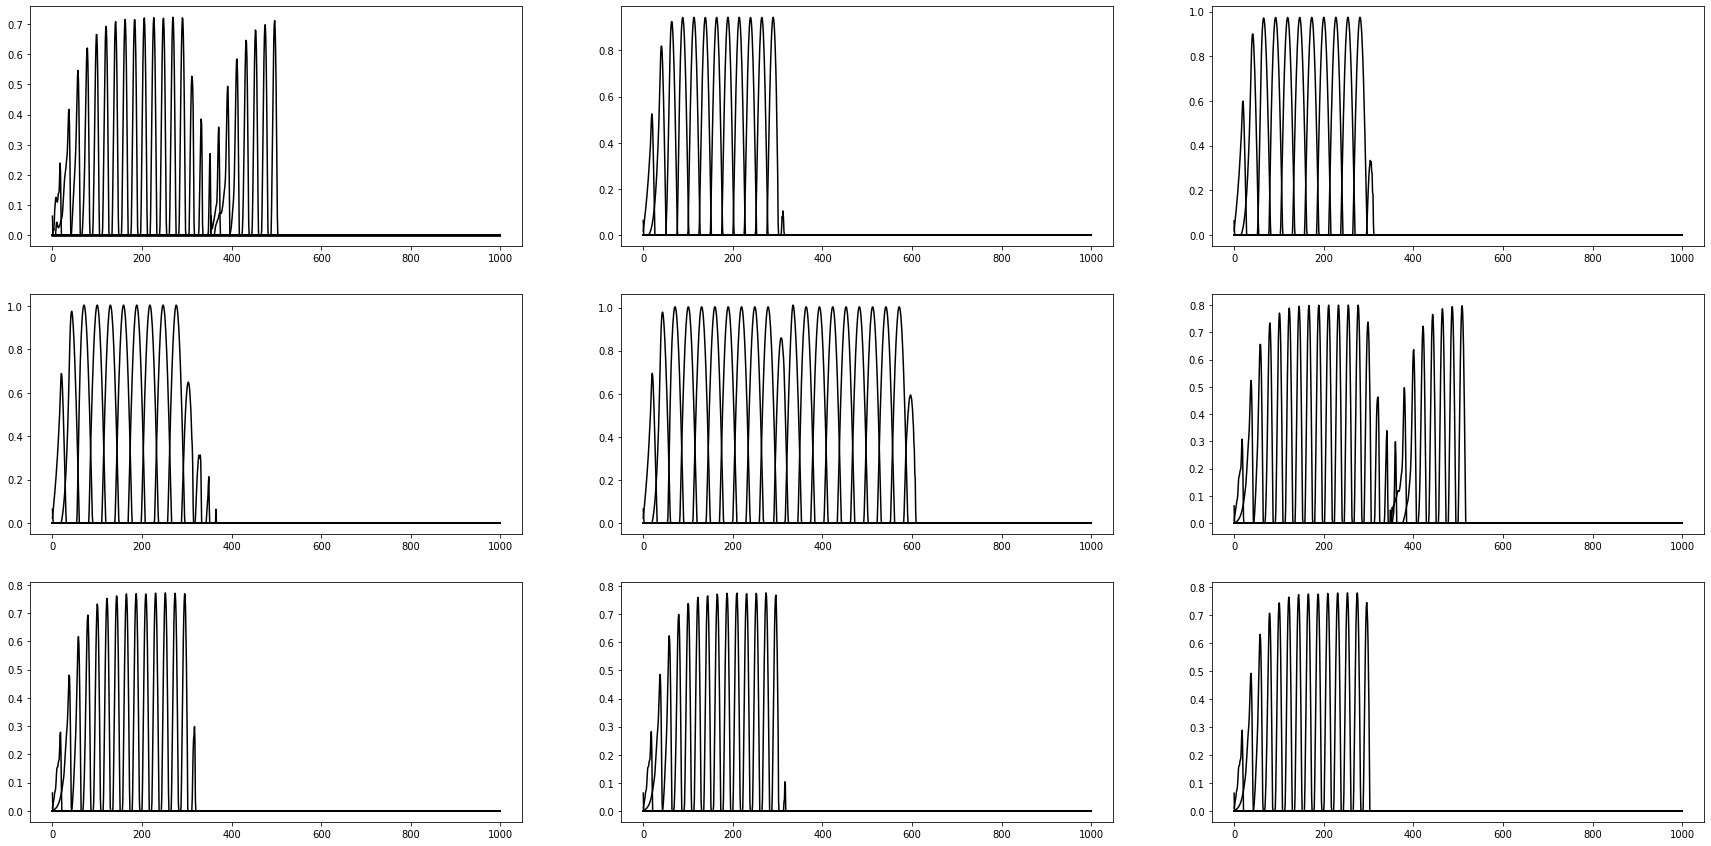

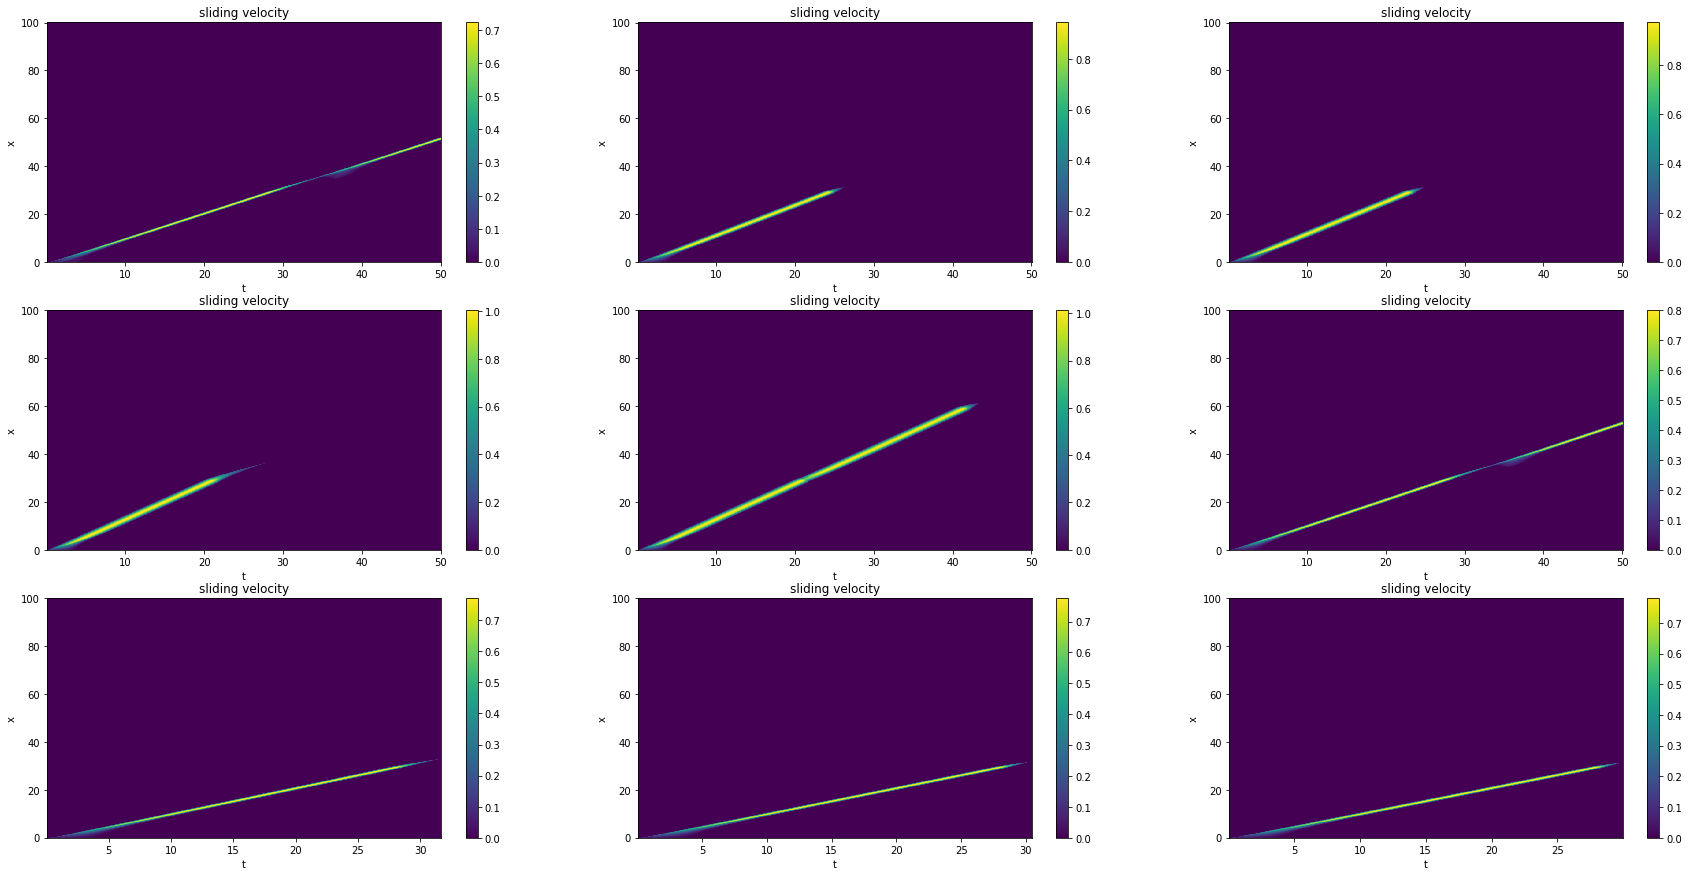

In [12]:
# Plot
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    Nmax = len(dataBarrier[runInd]['t'])
    plt.plot(dataBarrier[runInd]['v'][:,range(0,Nmax-1,20)],'k')
plt.show()

plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.pcolor(dataBarrier[runInd]['t'],dataBarrier[runInd]['x'],dataBarrier[runInd]['v'],shading='auto')
    plt.ylabel('x')
    plt.xlabel('t')
    plt.title('sliding velocity')
    plt.colorbar()
plt.show()


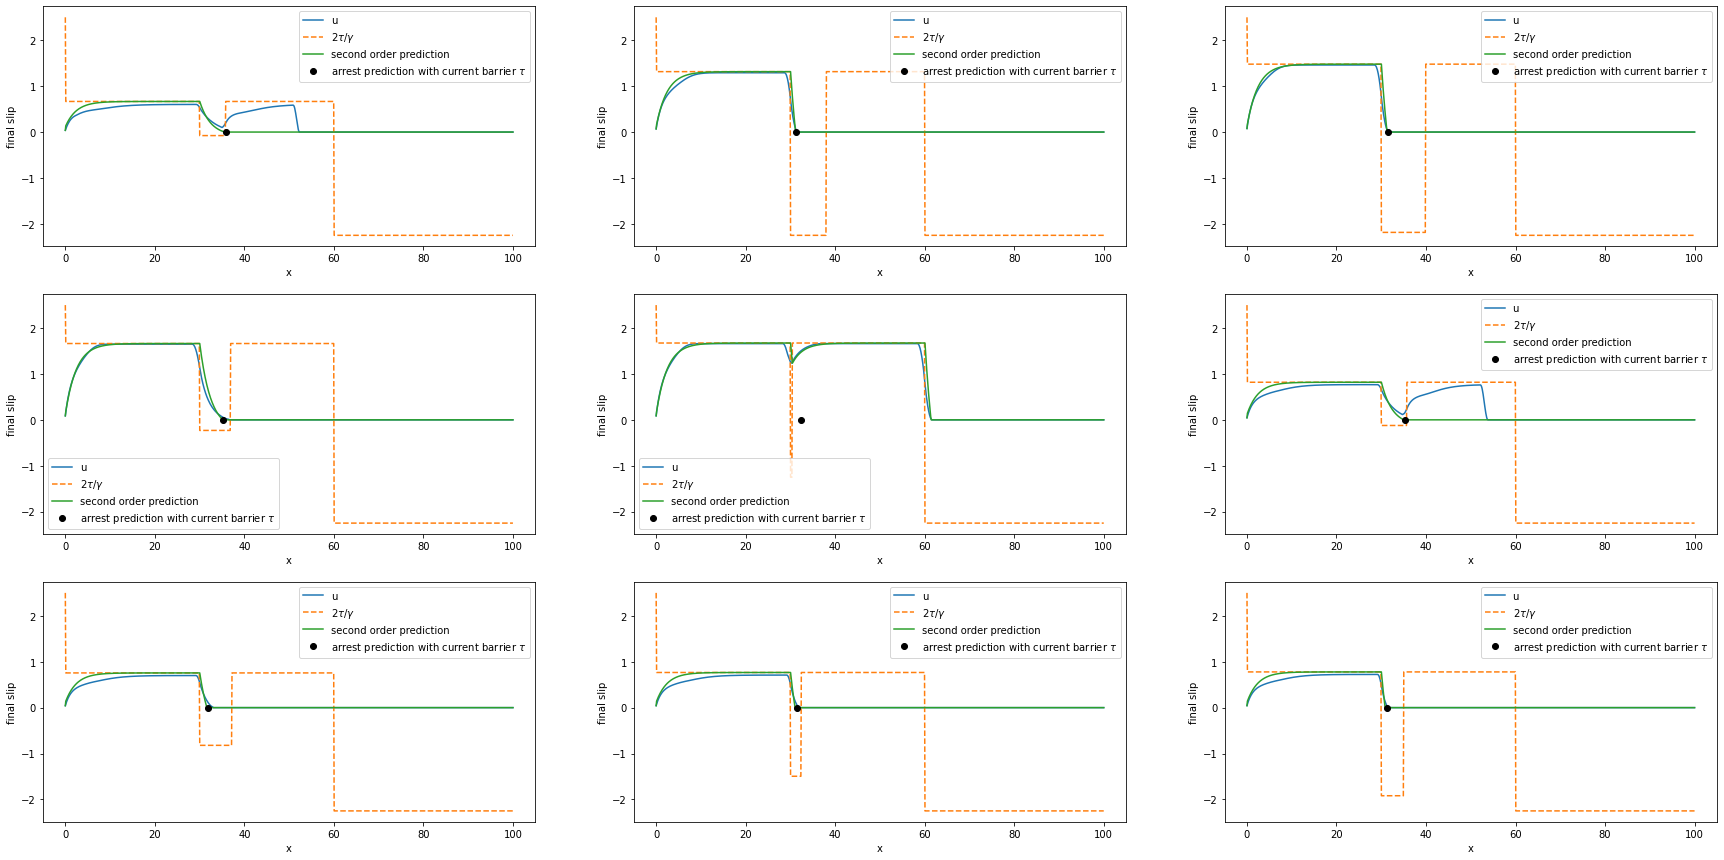

In [13]:
# Plot final slip
plt.figure(figsize=(30,15))
for runInd in range(N_runs):
    
    start = 0
    
    # calculate prediction:
    xP = dataBarrier[runInd]['x']
    tau = dataBarrier[runInd]['tau']
    gamma = dataBarrier[runInd]['gamma']
    u_pred = np.zeros(np.size(xP))
    u_pred[start]=dataBarrier[runInd]['u'][start,-1];

    for i in range(start+1,len(xP)):
        stress_drop = 2*tau[i-1]
        dxP = xP[i]-xP[i-1]
        u_pred[i] = u_pred[i-1] + .5*(stress_drop - gamma*u_pred[i-1])*dxP
    
    # Prediction of arrest where u_pred<0
    try:
        ind = np.where(u_pred<0)
        u_pred[ind[0][0]:]=0
    except:
        pass
    
    L_arrest = 2*np.log(-(dataBarrier[runInd]['u'][299,-1] - 2*dataBarrier[runInd]['tau'][300]/dataBarrier[runInd]['gamma'])/(2*dataBarrier[runInd]['tau'][300]))/dataBarrier[runInd]['gamma']
    
    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataBarrier[runInd]['x'],dataBarrier[runInd]['u'][:,-1],label='u')

    plt.plot(dataBarrier[runInd]['x'],2*dataBarrier[runInd]['tau']/dataBarrier[runInd]['gamma'],label='$2\\tau/\\gamma$',linestyle='--')
    plt.plot(dataBarrier[runInd]['x'],u_pred,label='second order prediction',linestyle='-')
    plt.plot(dataBarrier[runInd]['x'][300]+L_arrest,0,'ok',label='arrest prediction with current barrier $\\tau$')
    
    plt.xlabel('x')
    plt.ylabel('final slip')
    
    plt.legend()
plt.show()


# TODO: PLot the prediction of arrest in the same figure.

## Arrest phase diagram:

We set up pulses for arrest using the steady state solution (choose $u(0) = 2\tau/\gamma$). This reduces the arrest length approximation to

\begin{equation}
L_{arrest} = \frac{2 \log(\frac{\tau_{barrier} - \tau}{\tau_{barrier}})}{\gamma}
\end{equation}

In the following, we set up a fixed $\gamma = 0.7$ and vary $\tau$ and $\tau_{barrier}$ to create a 2D phase diagram of the arrest length


In [14]:
import time
dt = 1e-3
tmax = 100
gamma = 0.7
beta = 0.1
output_interval = 1000
x = np.linspace(0,100,1000)
barrierInd = 300

tau_all = np.linspace(0.1,.9,10)
tau_barrier_all = -np.linspace(0.1,.9,10)

L_arrest = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])
L_prediction = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])

for i in range(np.size(tau_all)):
    print(i)
    for j in range(np.size(tau_barrier_all)):

        tau = tau_all[i]*np.ones(np.size(x))
        tau[0:10]=1
    
        tau[barrierInd:]=tau_barrier_all[j]

        # run
        t = time.time()
        # do stuff

        data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
        print(time.time() - t)
    
        # Find L_arrest
        L_arrest[i,j]=x[np.max(np.where(data['u'][:,-1]>0))]-x[barrierInd]
        
        # Calculate prediction:
        L_prediction[i,j]=2/gamma*np.log((tau_barrier_all[j]-tau_all[i])/tau_barrier_all[j])

0
5.21199893951416
5.367980003356934
5.251766681671143
5.2581048011779785
5.226552724838257
5.376957178115845
5.174767971038818
5.061089038848877
5.278471946716309
5.093808889389038
1
4.883868217468262
4.507694959640503
4.639286994934082
4.826087951660156
4.567431926727295
4.632091760635376
4.708064079284668
4.694627046585083
4.616606950759888
4.726104736328125
2
4.542945146560669
4.380655765533447
4.425417900085449
4.4852752685546875
4.337992906570435
4.328733921051025
4.373287916183472
4.245488882064819
4.268165111541748
3.976550817489624
3
4.504296779632568
4.134450912475586
4.043982028961182
4.004356145858765
3.9496638774871826
3.644566059112549
3.7176687717437744
3.7791261672973633
3.589771032333374
3.650416851043701
4
3.785494089126587
3.6170759201049805
3.3733789920806885
3.6186180114746094
3.4877371788024902
3.438026189804077
3.373703956604004
3.2887942790985107
3.4287290573120117
3.401036024093628
5
3.3521728515625
3.129167079925537
3.0997419357299805
3.099483013153076
3.05123

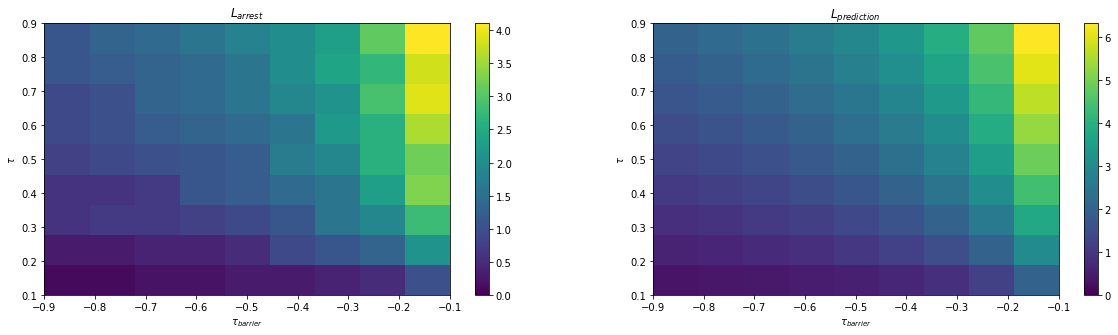

In [15]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.pcolor(tau_barrier_all,tau_all,L_arrest,vmin=0)
plt.colorbar()
plt.xlabel('$\\tau_{barrier}$')
plt.ylabel('$\\tau$')
plt.title('$L_{arrest}$')

plt.subplot(1,2,2)
plt.pcolor(tau_barrier_all,tau_all,L_prediction,vmin=0)
plt.colorbar()
plt.xlabel('$\\tau_{barrier}$')
plt.ylabel('$\\tau$')
plt.title('$L_{prediction}$')
plt.show()

The next we can do is to select a size of the barrier $L$, and measure the arrest length only if the rupture stops:
    

In [16]:
dt = 1e-3
gamma = 0.7
beta = 0.1
output_interval = 100
tmax = 50
x = np.linspace(0,50,500)
barrierInd = 250
barrierEnd = 275
L_barrier = x[barrierEnd]-x[barrierInd]

tau_all = np.linspace(0.1,.9,10)
tau_barrier_all = -np.linspace(0.1,.9,10)

L_arrest = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])
L_prediction = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])

for i in range(np.size(tau_all)):
    print(i)
    for j in range(np.size(tau_barrier_all)):

        tau = tau_all[i]*np.ones(np.size(x))
        tau[0:10]=1
    
        tau[barrierInd:]=tau_barrier_all[j]
        tau[barrierEnd:]=tau_all[i]
        tau[400:]=-.9

        # run
        t = time.time()
        # do stuff

        data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
        print(time.time() - t)
    
        # Find L_arrest
        L_arrest[i,j]=x[np.max(np.where(data['u'][:,-1]>0))]-x[barrierInd]
        if L_arrest[i,j]>L_barrier:
            L_arrest[i,j]=-1

0
4.305200099945068
4.238435983657837
4.1551008224487305
4.196619033813477
4.10343599319458
4.028321981430054
4.0193541049957275
3.9740078449249268
4.068570852279663
3.96867299079895
1
3.7839701175689697
3.6316239833831787
3.602631092071533
3.5357320308685303
3.508780002593994
3.530341148376465
3.1513137817382812
3.3478846549987793
3.456045150756836
2.935029983520508
2
5.099982023239136
3.4715051651000977
3.187117099761963
3.296643018722534
3.325704336166382
3.289926052093506
3.2740867137908936
3.213054895401001
3.3262600898742676
3.261645793914795
3
4.806251764297485
3.4545059204101562
3.156715154647827
2.9958808422088623
2.9543840885162354
2.9522838592529297
2.904201030731201
2.8690357208251953
2.9211227893829346
2.8947560787200928
4
4.191792011260986
4.241118907928467
2.7530157566070557
2.705327033996582
2.7376179695129395
2.662766933441162
2.6398730278015137
2.621748924255371
2.6225879192352295
2.6093411445617676
5
3.797938823699951
3.827730178833008
2.452924966812134
2.47139787673

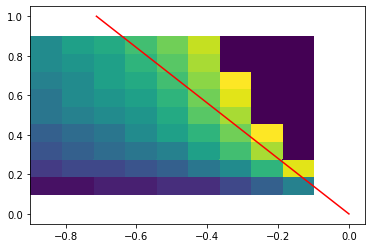

In [17]:

# Calculate prediction:
#exp(L_barrier*gamma/2) = (tau_barrier-tau)/tau_barrier
#tau_barrier*(1-exp(L_barrier*gamma/2)) = tau

plt.pcolor(tau_barrier_all,tau_all,L_arrest,vmin=0)
tb_plot = -np.linspace(0,1,1000)
t_plot = tb_plot*(1-np.exp(L_barrier*gamma/2))
t_plot[t_plot>1] = float('nan')
plt.plot(tb_plot,t_plot,'-r')

plt.show()





### Barriers: How can a (stress) barrier stop a crack?
To advance a crack one can use energy from the entire ruptured interface. This essentialy means that predicting the effect of a barrier is not different from predicting crack arrest as above. WE can simply solve
\begin{equation}
\int_0^L (\tau - a) dx
\end{equation}
for $L$. It is also worth noting that the size of the barrier required to arrest the rupture will have an implicit dependene on the crack length through the integral over positive $\tau$

@TODO: create a few examples

# Role of velocity weakening friction

There are a few different options here. We can do full rsf, or use velocity weakening as in ELbanna and Heaton. In the following, I have used a simple regularization with a characteristic velocity scale from the static to the dynamic level.

In [18]:
# Create a small dataset with different velocity weakening

dt = 1e-3
tmax = 50
gamma = 0.8
beta = 0.01
output_interval = 100
N_runs = 9
frictionParams = [10,20,30,40,50,100]
dataPulse = []

for runInd in range(N_runs):
    x = np.linspace(0,40*float(np.random.rand(1)+.3),1000)
    # Create tau from correlated noise:
    correlation_scale = .1+np.random.rand(1)
    filter_kernel = np.exp(-(x-np.max(x)/2)**2/(2*correlation_scale))
    filter_kernel = filter_kernel/np.sum(filter_kernel)
    noise = np.random.randn(np.size(x))
          
    noise = scipy.signal.convolve(noise, filter_kernel, mode='same')
    noise = noise-np.min(noise); noise = noise/np.max(noise)
    noise = noise*(1-np.exp(-x/5))
    randMod = .2+.8*np.random.rand(1)
    tau = randMod*noise+(1-randMod*(1-np.exp(-x/5)))-(x/np.max(x)) # Add linear background to noise
    tau[0:10]=1

    dataPulse.append([])
    for frictionInd in range(len(frictionParams)):
        # run
        dataPulse[runInd].append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta, frictionLaw = VelocityWeakeningFrictionLaw(weakeningConstant = frictionParams[frictionInd]) ) )
    

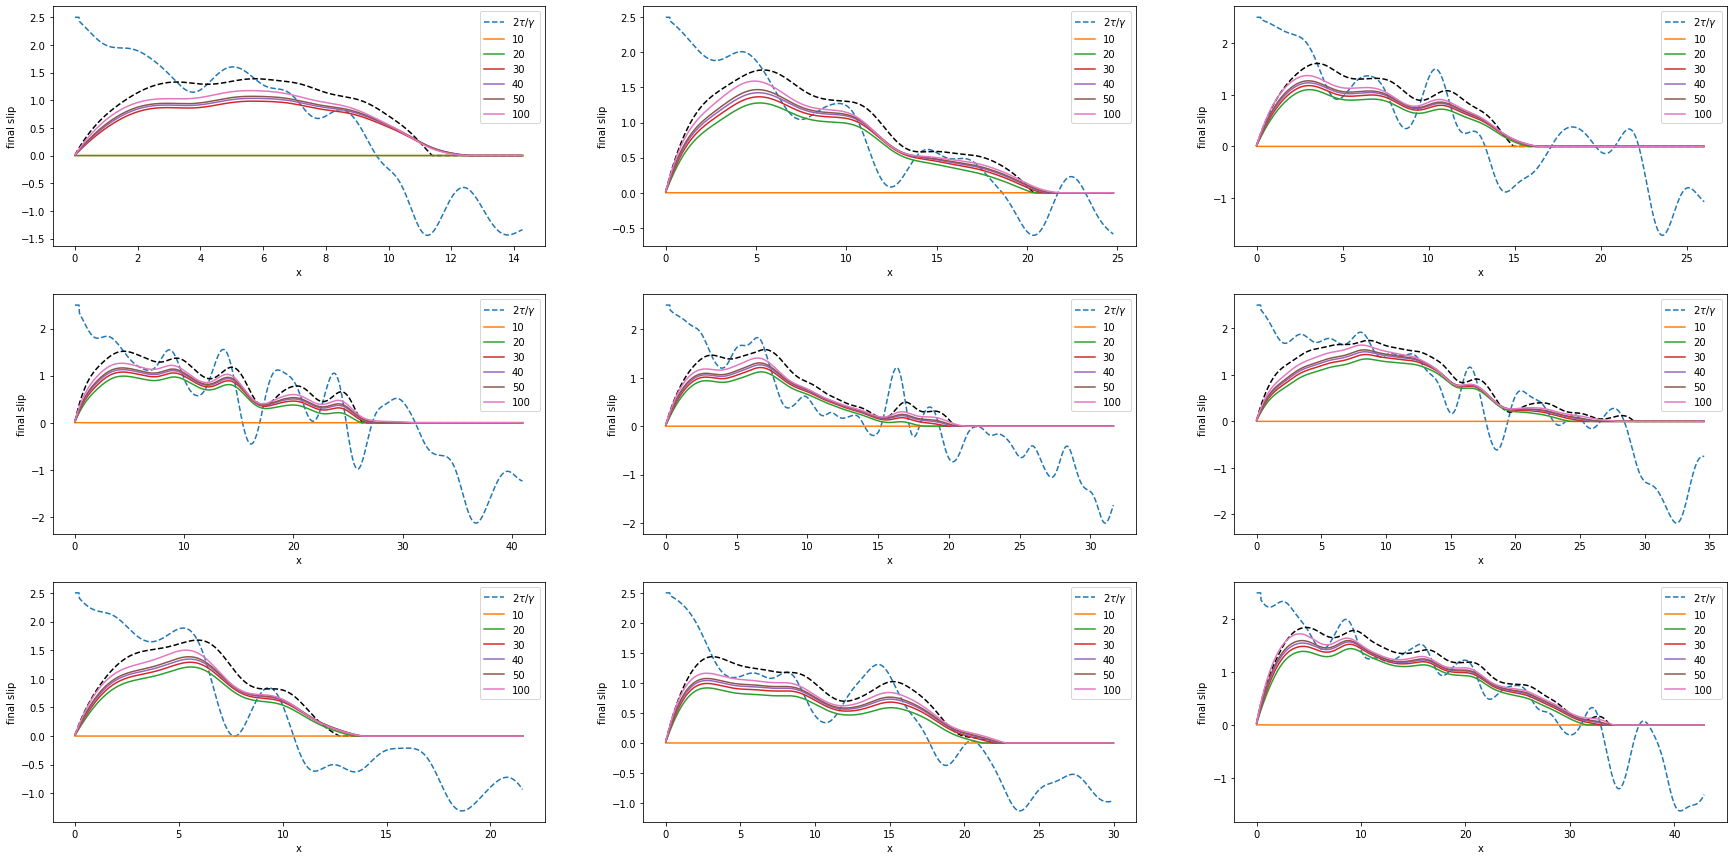

In [19]:
# Plot final slip
plt.figure(figsize=(30,15))
for runInd in range(N_runs):

    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataPulse[runInd][frictionInd]['x'],2*dataPulse[runInd][frictionInd]['tau']/dataPulse[runInd][frictionInd]['gamma'],label='$2\\tau/\\gamma$',linestyle='--')
    plt.plot(dataPulse[runInd][frictionInd]['x'],PulsePrediction(startPos = 0,u = dataPulse[runInd][frictionInd]['u'], x = dataPulse[runInd][frictionInd]['x'], tau = dataPulse[runInd][frictionInd]['tau'],gamma = dataPulse[runInd][frictionInd]['gamma']),'--k')

    for frictionInd in range(len(frictionParams)):
    
        try:
            plt.plot(dataPulse[runInd][frictionInd]['x'],dataPulse[runInd][frictionInd]['u'][:,-1],label=str(frictionParams[frictionInd]))
    
            plt.xlabel('x')
            plt.ylabel('final slip')

        except:
            pass
        
    plt.legend()
plt.show()

The effect of this type of velocity weakening is to reduce the final slip, which is not surprising since the friction force is always equal to or higher than for simple Amontons-Coulomb. This increases the fracture energy (but not in a trivial way due to the velocity dependence). It might be possible to predict the difference in slip, but it depends on how the pulse prediction can be adapted, and we probably need an estimate of average slip speed in the pulse.

# Role of slip weakening friction

In [20]:
# Create a small dataset with different slip weakening

dt = 1e-3
tmax = 50
gamma = 0.8
beta = 0.01
output_interval = 100
N_runs = 9
frictionParams = [25,50,100,500]
dataPulse = []

for runInd in range(N_runs):
    x = np.linspace(0,40*float(np.random.rand(1)+.3),1000)
    # Create tau from correlated noise:
    correlation_scale = .1+np.random.rand(1)
    filter_kernel = np.exp(-(x-np.max(x)/2)**2/(2*correlation_scale))
    filter_kernel = filter_kernel/np.sum(filter_kernel)
    noise = np.random.randn(np.size(x))
          
    noise = scipy.signal.convolve(noise, filter_kernel, mode='same')
    noise = noise-np.min(noise); noise = noise/np.max(noise)
    noise = noise*(1-np.exp(-x/5))
    randMod = .2+.8*np.random.rand(1)
    tau = randMod*noise+(1-randMod*(1-np.exp(-x/5)))-(x/np.max(x)) # Add linear background to noise
    tau[0:10]=1

    dataPulse.append([])
    for frictionInd in range(len(frictionParams)):
        # run
        dataPulse[runInd].append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta, 
                                                   frictionLaw = SlipWeakeningFrictionLaw(weakeningConstant = frictionParams[frictionInd], delta_u = x*0) ) )
    

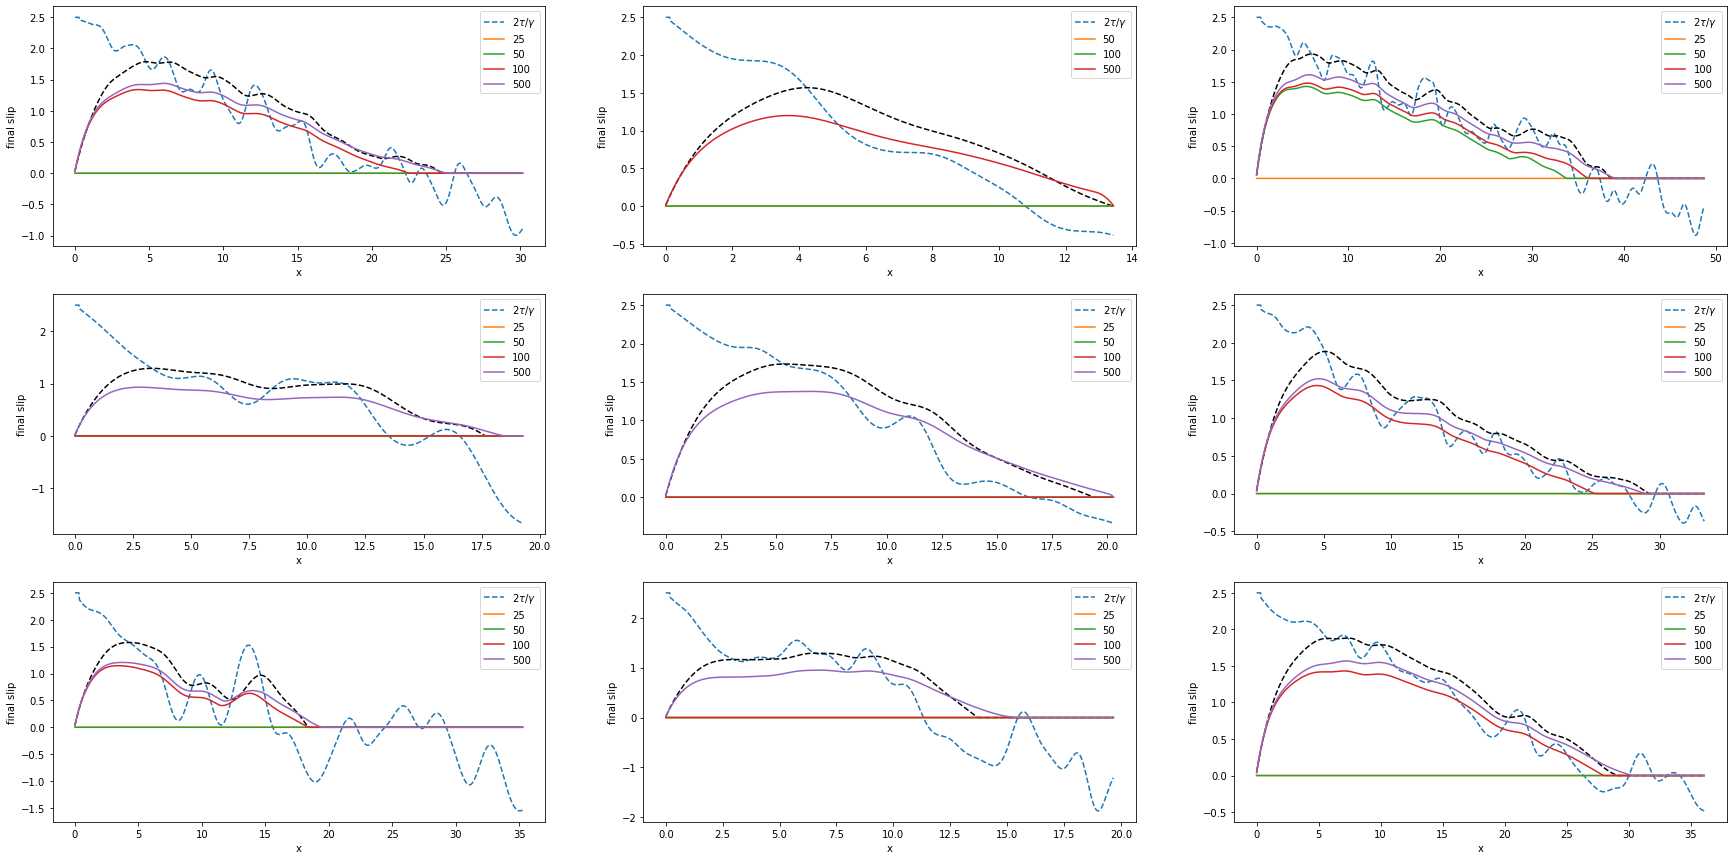

In [21]:
# Plot final slip
plt.figure(figsize=(30,15))
for runInd in range(N_runs):

    plt.subplot(3,int(np.ceil(N_runs/3)),runInd+1)
    plt.plot(dataPulse[runInd][frictionInd]['x'],2*dataPulse[runInd][frictionInd]['tau']/dataPulse[runInd][frictionInd]['gamma'],label='$2\\tau/\\gamma$',linestyle='--')
    plt.plot(dataPulse[runInd][frictionInd]['x'],PulsePrediction(startPos = 0,u = dataPulse[runInd][frictionInd]['u'], x = dataPulse[runInd][frictionInd]['x'], tau = dataPulse[runInd][frictionInd]['tau'],gamma = dataPulse[runInd][frictionInd]['gamma']),'--k')

    for frictionInd in range(len(frictionParams)):
    
        try:
            plt.plot(dataPulse[runInd][frictionInd]['x'],dataPulse[runInd][frictionInd]['u'][:,-1],label=str(frictionParams[frictionInd]))
    
            plt.xlabel('x')
            plt.ylabel('final slip')

        except:
            pass
        
    plt.legend()
plt.show()

The effect is similar to the velocity weakening effect. The fracture energy increases whit increaseing weakening distance.